In [1]:
import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)

    with open(config_dir / "kaggle.json", "w") as dst:
        with open("../kaggle.json", "r") as src:
            dst.write(src.read())

In [19]:
import os
import sys

sys.path.append(os.path.abspath(".."))

from ARISA_DSML.config import RAW_DATA_DIR, CSV_NAME, MODEL_NAME, target
from ARISA_DSML.preproc import get_raw_data

In [3]:
from ARISA_DSML.helpers import get_active_branch_name, get_git_commit_hash

get_active_branch_name("..")  # need ".." because we are not in root
get_git_commit_hash()

'68f5a4f7c8986003e3b00e5fb2e36490a03ce956'

In [4]:
get_raw_data()
!dir "{RAW_DATA_DIR}"

2025-05-07 21:29:47.676 | INFO     | ARISA_DSML.preproc:get_raw_data:21 - Downloading dataset shahnawaj9/diabetes-database to C:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment-KK\data\raw


Dataset URL: https://www.kaggle.com/datasets/shahnawaj9/diabetes-database


2025-05-07 21:29:48.172 | INFO     | ARISA_DSML.preproc:get_raw_data:24 - Download complete.


 Volume in drive C has no label.
 Volume Serial Number is D0EF-588E

 Directory of C:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment-KK\data\raw

07.05.2025  21:29    <DIR>          .
07.05.2025  21:29    <DIR>          ..
07.05.2025  21:29            23�873 diabetes.csv
07.05.2025  21:29            23�290 diabetes_Dataset_cleaned.csv
               2 File(s)         47�163 bytes
               2 Dir(s)  110�649�307�136 bytes free


In [7]:
from ARISA_DSML.preproc import preprocess_df

train_path, test_path = preprocess_df(RAW_DATA_DIR / CSV_NAME)

2025-05-07 21:31:08.132 | INFO     | ARISA_DSML.preproc:preprocess_df:59 - Train saved to C:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment-KK\data\processed\train.csv, Test saved to C:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment-KK\data\processed\test.csv


In [8]:
import pandas as pd
df_train = pd.read_csv(train_path)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               614 non-null    int64  
 1   glucose                   614 non-null    int64  
 2   bloodpressure             614 non-null    int64  
 3   skinthickness             614 non-null    int64  
 4   insulin                   614 non-null    int64  
 5   bmi                       614 non-null    float64
 6   diabetespedigreefunction  614 non-null    float64
 7   age                       614 non-null    int64  
 8   outcome                   614 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 43.3 KB


In [9]:
y_train = df_train.pop(target)
X_train = df_train

In [11]:
import mlflow
from ARISA_DSML.train import run_hyperopt, get_or_create_experiment

mlflow.set_tracking_uri(f"http://127.0.0.1:5000")

experiment_id = get_or_create_experiment("diabetes_hyperparam_tuning")
mlflow.set_experiment(experiment_id=experiment_id)
best_params_path = run_hyperopt(X_train, y_train)

2025-05-07 21:35:46.984 | INFO     | ARISA_DSML.train:run_hyperopt:71 - Best Parameters: {'depth': 6, 'learning_rate': 0.2997467303248517, 'iterations': 258, 'l2_leaf_reg': 29.31565918827504, 'bagging_temperature': 0.5200854166591251, 'random_strength': 0.0057443330613406365}


In [12]:
import joblib
from ARISA_DSML.train import train_cv
params = joblib.load(best_params_path)
n_folds = 5
cv_output_path = train_cv(X_train, y_train, params, n=n_folds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.6948640	test: 0.7126437	best: 0.7126437 (0)	total: 149ms	remaining: 38.2s
1:	learn: 0.7084639	test: 0.6666667	best: 0.7126437 (0)	total: 150ms	remaining: 19.2s
2:	learn: 0.7378049	test: 0.7228916	best: 0.7228916 (2)	total: 152ms	remaining: 12.9s
3:	learn: 0.7324841	test: 0.6493506	best: 0.7228916 (2)	total: 153ms	remaining: 9.7s
4:	learn: 0.7515924	test: 0.6493506	best: 0.7228916 (2)	total: 154ms	remaining: 7.8s
5:	learn: 0.7483871	test: 0.6400000	best: 0.7228916 (2)	total: 155ms	remaining: 6.52s
6:	learn: 0.7721519	test: 0.6400000	best: 0.7228916 (2)	total: 157ms	remaining: 5.61s
7:	learn: 0.7731629	test: 0.6329114	best: 0.7228916 (2)	total: 158ms	remaining: 4.93s
8:	learn: 0.7848101	test: 0.6329114	best: 0.7228916 (2)	total: 159ms	remaining: 4.4s
9:	learn: 0.7934426	test: 0.6153846	best: 0.7228916 (2)	total: 160ms	remaining: 3.97s
10:	learn: 0.7934426	test: 0.6153846	best: 0.7228916 (2)	total: 161ms	remaining: 3.63s
11:	learn: 0.8013029	test: 0.6329

In [13]:
from ARISA_DSML.train import plot_error_scatter
cv_results = pd.read_csv(cv_output_path)
plot_error_scatter(
    df_plot=cv_results, 
    name="Mean F1 Score", 
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xtitle="Training Steps",
    ytitle="Performance Score",
    yaxis_range=[0.5, 1]
)

In [14]:
plot_error_scatter(
    cv_results,
    x="iterations",
    y="test-Logloss-mean",
    err="test-Logloss-std",
    name="Mean logloss",
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xtitle="Training Steps",
    ytitle="Logloss",
)

In [15]:
from ARISA_DSML.train import train
params = joblib.load(best_params_path)
experiment_id = get_or_create_experiment("diabetes_full_training")
mlflow.set_experiment(experiment_id=experiment_id)
cv_results = pd.read_csv(cv_output_path)
model_path, model_params_path = train(X_train, y_train, params, cv_results=cv_results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5852251	total: 1.39ms	remaining: 356ms
50:	learn: 0.2154021	total: 60.6ms	remaining: 246ms
100:	learn: 0.1417086	total: 118ms	remaining: 184ms
150:	learn: 0.1024030	total: 176ms	remaining: 125ms
200:	learn: 0.0756838	total: 235ms	remaining: 66.5ms
250:	learn: 0.0605605	total: 292ms	remaining: 8.13ms
257:	learn: 0.0576874	total: 300ms	remaining: 0us


c:\Users\Wojciech\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:394: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

Successfully registered model 'diabetes-bclass'.
2025/05/07 21:36:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: diabetes-bclass, version 1
Create

In [16]:
df_test = pd.read_csv(test_path)

df_test.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,98,58,33,190,34.0,0.430,43,0
1,2,112,75,32,0,35.7,0.148,21,0
2,2,108,64,0,0,30.8,0.158,21,0
3,8,107,80,0,0,24.6,0.856,34,0
4,7,136,90,0,0,29.9,0.210,50,0


In [17]:
y_test = df_test.pop(target)
X_test = df_test

C:\Users\Wojciech\AppData\Local\Temp\ipykernel_10256\2097039018.py:6: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.1/model-registry.html#migrating-from-stages

C:\Users\Wojciech\AppData\Local\Temp\ipykernel_10256\2097039018.py:14: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.1/model-registry.html#migrating-from-stages



2025/05/07 21:38:53 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


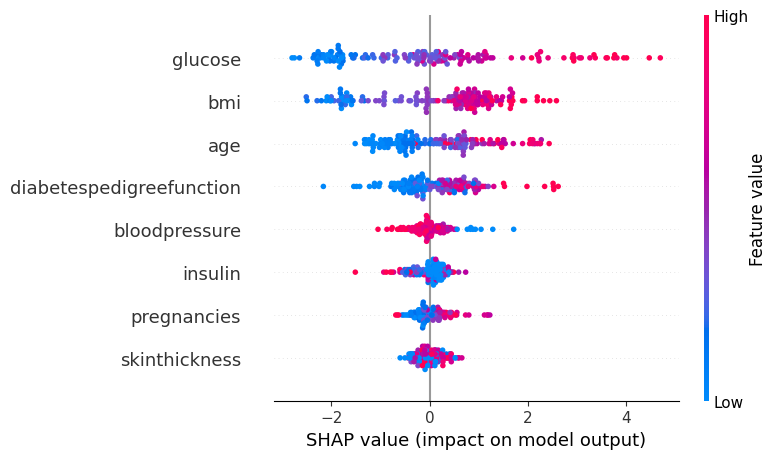

In [20]:
import json
from ARISA_DSML.predict import predict
from mlflow.client import MlflowClient

client = MlflowClient(mlflow.get_tracking_uri())
model_info = client.get_latest_versions(MODEL_NAME)[0]

# extract params/metrics data for run `test_run_id` in a single dict
run_data_dict = client.get_run(model_info.run_id).data.to_dictionary()
run = client.get_run(model_info.run_id)
log_model_meta = json.loads(run.data.tags['mlflow.log-model.history'])
log_model_meta[0]['signature']

latest_model = client.get_latest_versions(MODEL_NAME)

_, artifact_folder = os.path.split(latest_model[0].source)
model_uri = "runs:/{}/{}".format(latest_model[0].run_id, artifact_folder)
loaded_model = mlflow.catboost.load_model(model_uri)

params = run_data_dict["params"]
params["feature_columns"] = [inp["name"] for inp in json.loads(log_model_meta[0]['signature']['inputs'])]
preds_path = predict(loaded_model, df_test, params)

In [21]:
from ARISA_DSML.resolve import get_model_by_alias
client = MlflowClient(mlflow.get_tracking_uri())
champ_mv = get_model_by_alias(client)
chall_mv = get_model_by_alias(client, alias="challenger")

No champion model, predicting using newest model
runs:/896215f28d964b84b8695ea7dba46dc8/model


C:\Users\Wojciech\AppData\Local\Temp\ipykernel_10256\2109093237.py:6: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.1/model-registry.html#migrating-from-stages



2025/05/07 21:39:08 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


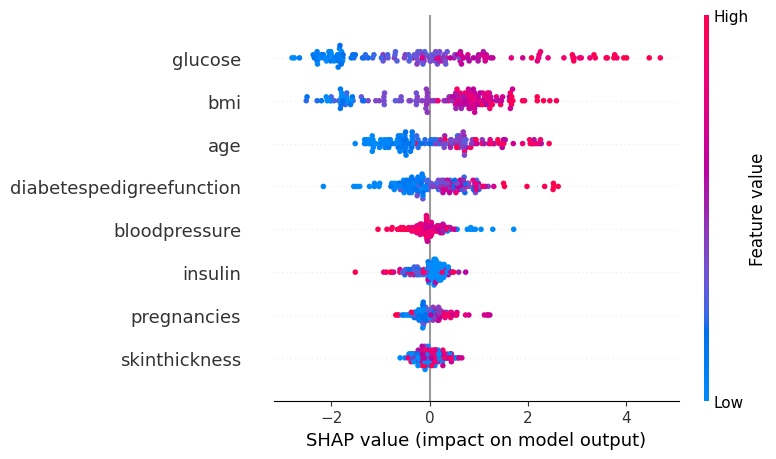

In [22]:
from ARISA_DSML.config import MODEL_NAME
client = MlflowClient(mlflow.get_tracking_uri())
model_info = get_model_by_alias(client, alias="champion")
if model_info is None:
    print("No champion model, predicting using newest model")
    model_info = client.get_latest_versions(MODEL_NAME)[0]

# extract params/metrics data for run `test_run_id` in a single dict 
run_data_dict = client.get_run(model_info.run_id).data.to_dictionary()
run = client.get_run(model_info.run_id)
log_model_meta = json.loads(run.data.tags['mlflow.log-model.history'])
log_model_meta[0]['signature']


_, artifact_folder = os.path.split(model_info.source)
model_uri = "runs:/{}/{}".format(model_info.run_id, artifact_folder)
print(model_uri)
loaded_model = mlflow.catboost.load_model(model_uri)

params = run_data_dict["params"]
params["feature_columns"] = [inp["name"] for inp in json.loads(log_model_meta[0]['signature']['inputs'])]
preds_path = predict(loaded_model, df_test, params)